### Import all required libraries

In [ ]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from collections import defaultdict
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, f1_score
import time
from sklearn.datasets import make_classification
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import tensorly as tl
from tltorch.factorized_layers import TCL
from sklearn.neural_network import MLPClassifier
from datetime import datetime
import keras
from keras import models, layers
import pandas as pd

## Load the data

Labels shape: (145, 145)
Hypercube shape: (145, 145, 200)


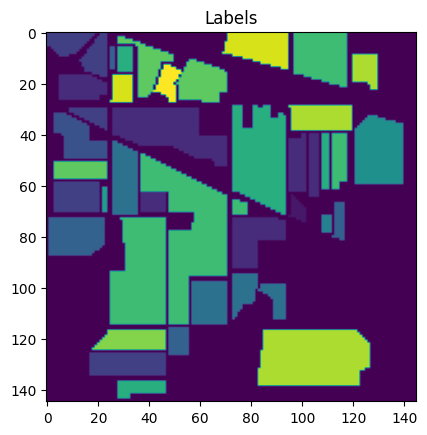

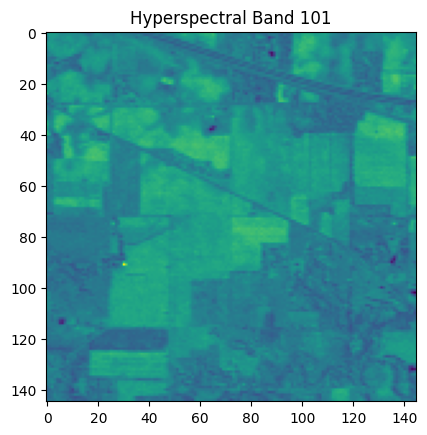

In [41]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'


# list of datasets
gt_files = ['Pavia_gt.mat', 'Botswana_gt.mat', 'Indian_pines_gt.mat', 'KSC_gt.mat', 'Salinas_gt.mat']
data_files = ['Pavia.mat', 'Botswana.mat', 'Indian_pines_corrected.mat', 'KSC.mat', 'Salinas_corrected.mat']
label_files = ['pavia_gt', 'Botswana_gt', 'indian_pines_gt', 'KSC_gt', 'salinas_gt']
hypercube_files = ['pavia', 'Botswana', 'indian_pines_corrected', 'KSC', 'salinas_corrected']

def extract_Features(index):
    # Load the ground truth labels and the hyperspectral data
    gt_file = 'Datasets/' + gt_files[index]
    data_file = 'Datasets/' + data_files[index]

    # TODO: Use if using Colab
    # gt_file = '/content/drive/My Drive/TNN/dataset/' + gt_files[index]
    # data_file = '/content/drive/My Drive/TNN/dataset/' + data_files[index]


    gt = sio.loadmat(gt_file)
    labels = gt[label_files[index]]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files[index]]
    # Scale the data in place and set to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)

    # Show shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    # Visualize the label map and a random band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features(2)

In [42]:
background = np.where(labels==0)
print(background[0].shape)
print(np.unique(labels))
print(5//2)

(10776,)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
2


### Extract Windows

In [43]:
def extract_windows(data, labels, window_size):
    """
    Extract patches (windows) from hyperspectral data, corresponding labels, and center coordinates.

    Parameters:
    data: 3D numpy array (H, W, Bands) - the hyperspectral image cube
    labels: 2D numpy array (H, W) - the ground truth labels
    window_size: int - the size of the window to extract around each pixel

    Returns:

    X_windows: List of 3D numpy arrays containing the patches from the hyperspectral image
    y_labels: List of corresponding labels for the center pixel of each window
    coordinates: List of tuples containing (row, col) coordinates of the center pixel
    """
    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []
    y_labels = []
    coordinates = []

    # Loop through each pixel in the original (non-padded) image
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            # Extract the window from the hyperspectral data
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
              X_windows.append(window)
              y_labels.append(label)
              coordinates.append((i-margin, j-margin))  # Store the original coordinates

    return np.array(X_windows), np.array(y_labels), coordinates

# Define window size
window_size = 5

# Extract windows from hyperspectral data, labels, and get coordinates
X_windows, y_labels, coordinates = extract_windows(hypercube, labels, window_size)

# Print the shape of extracted data and some example coordinates
print(f"Extracted windows shape: {X_windows.shape}")
print(f"Corresponding labels shape: {y_labels.shape}")
print(f"Example coordinates: {coordinates[:5]}")


Extracted windows shape: (10249, 5, 5, 200)
Corresponding labels shape: (10249,)
Example coordinates: [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4)]


### Window Reconstruction

This was done as to ensure that the window extraction properly reflects the original labelled data

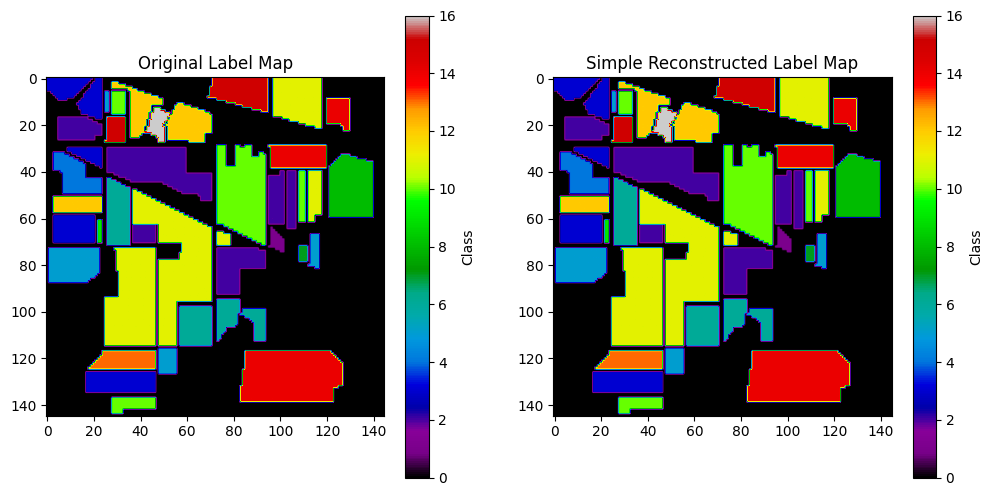

Do the original and reconstructed images match? True


In [44]:
def reconstruct(window_labels, coordinates, original_shape):
    simple_labels = np.zeros(original_shape, dtype=int)

    for idx, (i, j) in enumerate(coordinates):
        simple_labels[i, j] = window_labels[idx]  # Directly assign labels

    return simple_labels

# Run the simple reconstruction
reconstructed_labels = reconstruct(y_labels, coordinates, labels.shape)

# Check if simple reconstruction works
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(labels, cmap='nipy_spectral')
plt.title('Original Label Map')
plt.colorbar(label='Class')

plt.subplot(1, 2, 2)
plt.imshow(reconstructed_labels, cmap='nipy_spectral')
plt.title('Simple Reconstructed Label Map')
plt.colorbar(label='Class')

plt.show()

# Check if the two arrays match
arrays_match = np.array_equal(labels, reconstructed_labels)

print(f"Do the original and reconstructed images match? {arrays_match}")


### Sample Extraction

In [45]:
# Function that extracts a list of coordinates from the dataset
def get_samples(X_windows, y_labels, samples_per_class):
    # Unique classes in the dataset
    classes = np.unique(y_labels)

    # Containers for storing selected samples
    X_sampled = []
    y_sampled = []
    X_val = []
    y_val = []
    selected_indices_total = []
    validation_selected = []
    validation_total = []

    # Loop over each class and sample `samples_per_class` examples
    for cls in classes:
        # if label = 0, skip
        if cls == 0:
          continue
        # Get the indices for the current class
        class_indices = np.where(y_labels == cls)[0]

        # Shuffle class-specific indices
        np.random.shuffle(class_indices)

        # Select `samples_per_class` samples from this class
        selected_indices = class_indices[:samples_per_class]
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        selected_indices_total.extend(selected_indices)  # Store indices for later
        validation_total.extend(validation_selected)
        # Append the selected samples and their labels
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    # Concatenate the sampled arrays
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)
    y_train = y_train - 1  # Shift labels to start from 0

    # Concatenate the sampled arrays
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1  # Shift labels to start from 0

    # Create the test set from the remaining data (data not selected for training)
    selected_indices_total.extend(validation_total)
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)  # Indices not in training set
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1  # Shift labels to start from 0

    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

### Logistic Regression
#### Train and test the model

In [46]:
# Function to train and test the model, returning accuracy and classification report
def train_and_test_model(X_train, X_test, y_train, y_test):
    start_time = time.time()
    # Train the model
    model = LogisticRegression(penalty=None, max_iter=300)
    model.fit(X_train, y_train)
    end_time = time.time()

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    print(f"Accuracy: {accuracy:.2f}")
    print(f"F1 Micro: {f1_score(y_test, y_pred, average='micro'):.2f}")
    print(f"F1 Macro: {f1_score(y_test, y_pred, average='macro'):.2f}")
    print(f"F1 Weighted: {f1_score(y_test, y_pred, average='weighted'):.2f}")

    return accuracy, end_time - start_time


#### Run the Logistic Regression Model

In [47]:
# Function to compare different numbers of samples per class and evaluate model performance
def Logistic_Regression(X_train, X_test, y_train, y_test):
    results = {}

    # Flatten x_train and x_test
    X_train_flattened = X_train.reshape(X_train.shape[0], -1)  # Shape: (148152, 2550)
    X_test_flattened = X_test.reshape(X_test.shape[0], -1)  # Shape: (num_test_samples, 2550)

    print(X_train_flattened.shape)
    print(X_test_flattened.shape)

    # Train and test the model, returning accuracy
    accuracy = train_and_test_model(X_train_flattened, X_test_flattened, y_train, y_test)

    return accuracy


#### Print the results

In [48]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 10)
Logistic_Regression(X_train, X_test, y_train, y_test)

print(X_windows.shape)
print(y_labels.shape)

(160, 5000)
(10009, 5000)
Accuracy: 0.45
F1 Micro: 0.45
F1 Macro: 0.47
F1 Weighted: 0.46
(10249, 5, 5, 200)
(10249,)


### FCNN

#### Run FCNN
As an FCNN we are using MLP classifier by sklearn

In [49]:
def Fully_Connected_Neural_Network(X_train, X_test, y_train, y_test):
    results = {}
    #X_flattened = X_windows.reshape(X_windows.shape[0], -1)  # (num_samples, window_size * window_size * num_bands)
    X_train_flattened = X_train.reshape(X_train.shape[0], -1)
    X_test_flattened = X_test.reshape(X_test.shape[0], -1)

    # Initialize the MLPClassifier with 2 hidden layers of default sizes
    model = MLPClassifier(random_state=1, hidden_layer_sizes=(160,256), alpha=0.04, max_iter=350)

    start_time = time.time()
    # Fit the model to the training data
    model.fit(X_train_flattened, y_train)
    end_time = time.time()

    # Predict on the test set
    y_pred = model.predict(X_test_flattened)

    # Calculate test accuracy
    accuracy = accuracy_score(y_test, y_pred)

    print(f"Test Accuracy: {accuracy:.2f}")
    results = accuracy

    return results, end_time - start_time

### CNN
#### Samples from Classes

In [50]:
def sample_from_classes_cnn(X_train, X_test, y_train, y_test, X_val, y_val):
    classes = np.unique(y_labels)

    # Convert lists to numpy arrays
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    X_val = np.array(X_val)
    y_val = np.array(y_val)

    # Perform one-hot encoding
    y_train_encoded = keras.utils.to_categorical(y_train, num_classes=len(classes))
    y_test_encoded = keras.utils.to_categorical(y_test, num_classes=len(classes))
    y_val_encoded = keras.utils.to_categorical(y_val, num_classes=len(classes))
    return X_train, X_test, y_train_encoded, y_test_encoded, X_val, y_val_encoded # Return the encoded labels

#### CNN Architecture

In [51]:
# Set up CNN architecture parameters
c_r = 50
# Define the CNN model structure based on Makantasis et al.
def create_cnn(num_classes, shape):
    model = models.Sequential()

    # First Depthwise Separable Conv layer
    #model.add(layers.Conv2D(filters=3 * c_r, kernel_size=(3, 3), activation='sigmoid', padding='valid', input_shape=shape))
    model.add(layers.Conv2D(filters=150, kernel_size=(3, 3), activation='sigmoid', padding='valid', input_shape=shape))
    model.add(layers.BatchNormalization())

    # Second Depthwise Separable Conv layer
    #model.add(layers.Conv2D(filters=3 * (3 * c_r), kernel_size=(3, 3), activation='sigmoid', padding='valid'))
    model.add(layers.Conv2D(filters=300, kernel_size=(3, 3), activation='sigmoid', padding='valid'))
    model.add(layers.BatchNormalization())

    # Flatten the output to transition to Dense layers
    model.add(layers.Flatten())

    # Fully connected layers
    model.add(layers.Dense(196, activation='relu')) # 9 * c_r
    #model.add(layers.Dense(6 * c_r, activation='sigmoid'))

    # Output layer with softmax for multi-class classification
    model.add(layers.Dense(num_classes, activation='softmax'))
    print(num_classes)

    return model


#### Run CNN

In [52]:
def Convolutional_Neural_Network(X_train, X_test, y_train, y_test, X_val, y_val, epochs):
    # X_train, X_test, y_train, y_test = sample_from_classes_cnn(X_train, X_test, y_train, y_test)
    shape = X_train[0].shape
    print(shape)

    callback = keras.callbacks.EarlyStopping(
                    monitor="val_acc",
                    min_delta=0,
                    patience=50,
                    verbose=0,
                    mode="max",
                    baseline=None,
                    restore_best_weights=False,
                    start_from_epoch=0,
                )
    # Rebuild and compile model for each sample size
    num_classes = len(np.unique(y_labels))
    #model = create_cnn((num_classes), shape)
    model = create_cnn(num_classes, shape)
    # Compile the model with the new optimizer
    model.compile(optimizer='adam', loss=keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

    start_time = time.time()

    history = model.fit(X_train,
                        y_train,
                        epochs=epochs,
                        validation_data=(X_val, y_val),
                        batch_size=256,
                        callbacks=[callback],
                        verbose=1
                        )
    
    end_time = time.time()

    # Evaluate model
    test_loss, accuracy = model.evaluate(X_test, y_test, verbose=2)
    results_test = accuracy

    train_loss, accuracy = model.evaluate(X_train, y_train, verbose=2)
    results_train = accuracy

    return results_test, results_train, end_time - start_time


#### Test CNN

In [53]:
X_train, X_test, y_train, y_test, X_val, y_val = sample_from_classes_cnn(X_train, X_test, y_train, y_test, X_val, y_val)
results_test, results_train, CNN_time = Convolutional_Neural_Network(X_train, X_test, y_train, y_test, X_val, y_val, 1000)
print(results_test)
print(results_train)
print(CNN_time)

(5, 5, 200)
16
Epoch 1/1000


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.0875 - loss: 3.1909 - val_accuracy: 0.0625 - val_loss: 2.9262
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.4250 - loss: 1.7949 - val_accuracy: 0.1250 - val_loss: 2.9326
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.6250 - loss: 1.3715

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.6250 - loss: 1.3715 - val_accuracy: 0.0625 - val_loss: 2.9423
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.7188 - loss: 1.0849 - val_accuracy: 0.0625 - val_loss: 2.9522
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.7250 - loss: 0.9050 - val_accuracy: 0.0625 - val_loss: 2.9587
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.7750 - loss: 0.8182 - val_accuracy: 0.0625 - val_loss: 2.9597
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.8062 - loss: 0.6741 - val_accuracy: 0.0625 - val_loss: 2.9631
Epoch 8/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.8188 - loss: 0.6119 - val_accuracy: 0.0625 - val_loss: 2.9687
Epoch 9/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.8500 - loss: 0.5338 - val_accuracy: 0.0625 - val_loss: 2.9740
Epoch 10/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.8813 - loss: 0.4740 - val_accuracy: 0.0625 - val_loss: 

### TNN

In [54]:
# TODO: Use if using Colab
# !pip install tensorly tensorly-torch

#### TNN Architecture

In [55]:
tl.set_backend('pytorch')

class TensorNet(nn.Module):
    def __init__(self, input_shape, num_of_classes):
        super(TensorNet, self).__init__()
        self.tcl1 = TCL(input_shape=input_shape, rank=(256, 5, 5))
        self.tcl1.reset_parameters()
        self.bn1 = nn.BatchNorm2d(256)
        self.tcl2 = TCL(input_shape=(256, 5, 5), rank=(256, 3, 3))
        self.tcl2.reset_parameters()
        self.bn2 = nn.BatchNorm2d(256)
        self.tcl3 = TCL(input_shape=(256, 3, 3), rank=(128, 3, 3))
        self.tcl3.reset_parameters()
        self.bn3 = nn.BatchNorm2d(128)
        self.tcl4 = TCL(input_shape=(128, 3, 3), rank=(128, 1, 1))
        self.tcl4.reset_parameters()
        self.bn4 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128 * 1 * 1, 64)
        nn.init.kaiming_uniform_(self.fc1.weight, mode='fan_in', nonlinearity='relu')
        self.bn5 = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(64, num_of_classes)


    def forward(self, x):
        x = F.relu(self.bn1(self.tcl1(x)))
        x = F.relu(self.bn2(self.tcl2(x)))
        x = F.relu(self.bn3(self.tcl3(x)))
        x = F.relu(self.bn4(self.tcl4(x)))
        x = torch.flatten(x, start_dim=1)
        x = F.sigmoid(self.bn5(self.fc1(x)))
        x = self.fc2(x)
        return x

#### Run TNN

In [56]:
def Tensor_Neural_Network(X_train, X_test, X_val, y_train, y_test, y_val, num_of_classes, epochs, patience=100):

    X_train = np.moveaxis(X_train, 3, 1)
    X_test = np.moveaxis(X_test, 3, 1)
    X_val = np.moveaxis(X_val, 3, 1)

    train_dataset = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
    val_dataset = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
    test_dataset = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

    trainloader = DataLoader(train_dataset, shuffle=True, batch_size=256)
    valloader = DataLoader(val_dataset, shuffle=False, batch_size=256)
    testloader = DataLoader(test_dataset, shuffle=False, batch_size=256)

    model = TensorNet(X_train[0].shape, num_of_classes=num_of_classes)
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    best_val_loss = 999
    patience_counter = 0
    best_model_state = None

    start_time = time.time()
    
    # Training loop with validation
    for epoch in range(epochs + 1):
        model.train()
        total_loss = 0
        for windows, labels in trainloader:
            predictions = model(windows)
            loss = criterion(predictions, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Compute validation accuracy
        model.eval()
        correct = 0
        total = 0
        val_loss = 0.0
        with torch.no_grad():
            for windows, labels in valloader:
                predictions = model(windows)
                loss = criterion(predictions, labels)
                val_loss += loss.item()

        val_loss /= len(valloader)

        if epoch % 10 == 0:
            print(f'Epoch [{epoch}/{epochs}], Loss: {total_loss/len(trainloader):.4f}, Val Loss: {val_loss:.4f}')

        # Check if the current model is the best
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()  # Save the best model state
            patience_counter = 0  # Reset counter if loss improves
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}, best val loss: {best_val_loss:.4f}")
            break

    end_time = time.time()

    # Load the best model before testing
    if best_model_state:
        model.load_state_dict(best_model_state)

    # Final test accuracy
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for windows, labels in testloader:
            predictions = model(windows)
            _, predicted = torch.max(predictions.data, 1)
            _, ground_truth = torch.max(labels.data, 1)
            total += labels.size(0)
            correct += (predicted == ground_truth).sum().item()

    accuracy_test = correct / total
    print(f'Test Accuracy: {100 * accuracy_test:.2f}%')

    # Train accuracy computation
    correct = 0
    total = 0
    with torch.no_grad():
        for windows, labels in trainloader:
            predictions = model(windows)
            _, predicted = torch.max(predictions.data, 1)
            _, ground_truth = torch.max(labels.data, 1)
            total += labels.size(0)
            correct += (predicted == ground_truth).sum().item()

    accuracy_train = correct / total
    print(f'Train Accuracy: {100 * accuracy_train:.2f}%')

    return accuracy_test, end_time - start_time


#### Test TNN

In [57]:
tnn_test, tnn_time = Tensor_Neural_Network(X_train, X_test, X_val, y_train, y_test, y_val, 16, 1500)
print(tnn_test)
print(tnn_time)

Epoch [0/1500], Loss: 2.7911, Val Loss: 2.7891
Epoch [10/1500], Loss: 2.4302, Val Loss: 2.7760
Epoch [20/1500], Loss: 2.2206, Val Loss: 2.7784
Epoch [30/1500], Loss: 2.0227, Val Loss: 2.7815
Epoch [40/1500], Loss: 1.8458, Val Loss: 2.7789
Epoch [50/1500], Loss: 1.6933, Val Loss: 2.7483
Epoch [60/1500], Loss: 1.5341, Val Loss: 2.6748
Epoch [70/1500], Loss: 1.4430, Val Loss: 2.4909
Epoch [80/1500], Loss: 1.2659, Val Loss: 2.3175
Epoch [90/1500], Loss: 1.1140, Val Loss: 1.9518
Epoch [100/1500], Loss: 0.9928, Val Loss: 1.7482
Epoch [110/1500], Loss: 0.8704, Val Loss: 1.5348
Epoch [120/1500], Loss: 0.7681, Val Loss: 1.3870
Epoch [130/1500], Loss: 0.6682, Val Loss: 1.3116
Epoch [140/1500], Loss: 0.5857, Val Loss: 1.2421
Epoch [150/1500], Loss: 0.5154, Val Loss: 1.1507
Epoch [160/1500], Loss: 0.4547, Val Loss: 1.1165
Epoch [170/1500], Loss: 0.4027, Val Loss: 1.0766
Epoch [180/1500], Loss: 0.3580, Val Loss: 1.0422
Epoch [190/1500], Loss: 0.3195, Val Loss: 1.0050
Epoch [200/1500], Loss: 0.2865,

### Run all classifiers

This code runs all the classifiers 10 times, then storing the values withing the results excel files

Labels shape: (1096, 715)
Hypercube shape: (1096, 715, 102)


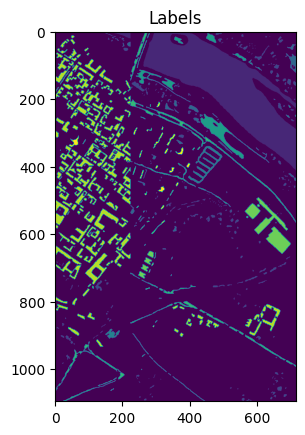

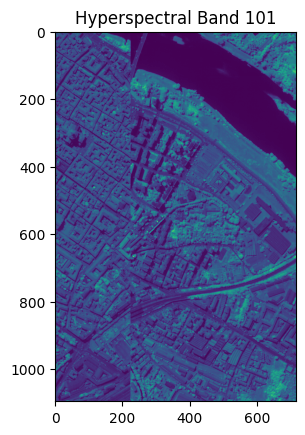

(45, 2550)
(148062, 2550)
Accuracy: 0.84
F1 Micro: 0.84
F1 Macro: 0.73
F1 Weighted: 0.86


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (350) reached and the optimization hasn't converged yet.
  warnings.warn(


Test Accuracy: 0.93
(5, 5, 102)
9


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.0222 - loss: 3.1676 - val_accuracy: 0.1111 - val_loss: 2.2808
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.4889 - loss: 1.3908 - val_accuracy: 0.1111 - val_loss: 2.2618
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.5333 - loss: 1.1101 - val_accuracy: 0.1111 - val_loss: 2.2474
Epoch 4/1000


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.6889 - loss: 0.8072 - val_accuracy: 0.1111 - val_loss: 2.2350
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.8222 - loss: 0.5167 - val_accuracy: 0.1111 - val_loss: 2.2237
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9333 - loss: 0.4613 - val_accuracy: 0.1111 - val_loss: 2.2120
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9556 - loss: 0.3780 - val_accuracy: 0.1111 - val_loss: 2.2002
Epoch 8/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9778 - loss: 0.3018 - val_accuracy: 0.1111 - val_loss: 2.1884
Epoch 9/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9556 - loss: 0.2760 - val_accuracy: 0.1111 - val_loss: 2.1774
Epoch 10/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9778 - loss: 0.2237 - val_accuracy: 0.1111 - val_loss: 2.1678
Epoch 11/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9778 - loss: 0.1902 - val_accuracy: 0.1111 - val_loss: 2

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (350) reached and the optimization hasn't converged yet.
  warnings.warn(


Test Accuracy: 0.96
(5, 5, 102)
9
Epoch 1/1000


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.1778 - loss: 2.7191 - val_accuracy: 0.1111 - val_loss: 2.3274
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.4222 - loss: 1.9660 - val_accuracy: 0.1111 - val_loss: 2.3059
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.7000 - loss: 0.8795 - val_accuracy: 0.1111 - val_loss: 2.2899
Epoch 4/1000


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.6889 - loss: 0.7643 - val_accuracy: 0.1111 - val_loss: 2.2774
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8222 - loss: 0.5796 - val_accuracy: 0.1556 - val_loss: 2.2698
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.8222 - loss: 0.5045 - val_accuracy: 0.2222 - val_loss: 2.2635
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9222 - loss: 0.4307 - val_accuracy: 0.2000 - val_loss: 2.2558
Epoch 8/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9444 - loss: 0.3807 - val_accuracy: 0.2000 - val_loss: 2.2467
Epoch 9/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9667 - loss: 0.3318 - val_accuracy: 0.1556 - val_loss: 2.2382
Epoch 10/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9444 - loss: 0.2938 - val_accuracy: 0.1111 - val_loss: 2.2306
Epoch 11/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9444 - loss: 0.2641 - val_accuracy: 0.1111 - val_loss: 2.

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.0267 - loss: 2.6453 - val_accuracy: 0.1111 - val_loss: 2.3454
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.4844 - loss: 1.2682 - val_accuracy: 0.1111 - val_loss: 2.3159
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.4356 - loss: 1.4346

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.4356 - loss: 1.4346 - val_accuracy: 0.1111 - val_loss: 2.2929
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7956 - loss: 0.6821 - val_accuracy: 0.1111 - val_loss: 2.2729
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.6933 - loss: 0.7976 - val_accuracy: 0.1111 - val_loss: 2.2562
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8000 - loss: 0.5736 - val_accuracy: 0.1111 - val_loss: 2.2441
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.7778 - loss: 0.5301 - val_accuracy: 0.1111 - val_loss: 2.2305
Epoch 8/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8000 - loss: 0.4750 - val_accuracy: 0.1111 - val_loss: 2.2146
Epoch 9/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8978 - loss: 0.3962 - val_accuracy: 0.1111 - val_loss: 2.1984
Epoch 10/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8933 - loss: 0.3888 - val_accuracy: 0.1556 - val_loss: 2.1

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 207ms/step - accuracy: 0.2337 - loss: 2.3356 - val_accuracy: 0.1111 - val_loss: 2.3440
Epoch 2/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.4617 - loss: 1.2125 - val_accuracy: 0.1111 - val_loss: 2.3058
Epoch 3/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8363 - loss: 0.7453 - val_accuracy: 0.1111 - val_loss: 2.2754
Epoch 4/1000


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8228 - loss: 0.5231 - val_accuracy: 0.1111 - val_loss: 2.2425
Epoch 5/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8837 - loss: 0.4192 - val_accuracy: 0.1111 - val_loss: 2.2139
Epoch 6/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8956 - loss: 0.3631 - val_accuracy: 0.1111 - val_loss: 2.1930
Epoch 7/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8963 - loss: 0.3128 - val_accuracy: 0.1111 - val_loss: 2.1717
Epoch 8/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8926 - loss: 0.3081 - val_accuracy: 0.1111 - val_loss: 2.1516
Epoch 9/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9169 - loss: 0.2373 - val_accuracy: 0.1111 - val_loss: 2.1395
Epoch 10/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8791 - loss: 0.2792 - val_accuracy: 0.1556 - val_loss: 2.1167
Epoch 11/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9212 - loss: 0.2268 - val_accuracy: 0.1556 - val_loss: 2.

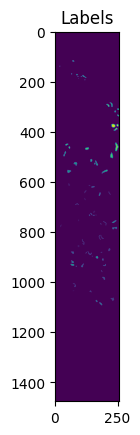

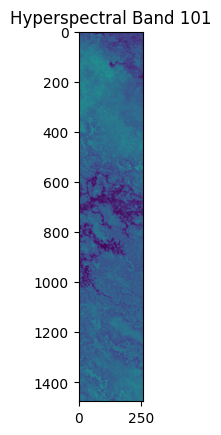

(70, 3625)
(3108, 3625)
Accuracy: 0.82
F1 Micro: 0.82
F1 Macro: 0.83
F1 Weighted: 0.81
Test Accuracy: 0.88
(5, 5, 145)
14
Epoch 1/1000


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (350) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.0429 - loss: 2.9667 - val_accuracy: 0.0714 - val_loss: 2.7654
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.2714 - loss: 2.1188 - val_accuracy: 0.0714 - val_loss: 2.7638
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.3714 - loss: 1.7763 - val_accuracy: 0.0714 - val_loss: 2.7650
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5429 - loss: 1.5328

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.5429 - loss: 1.5328 - val_accuracy: 0.0714 - val_loss: 2.7668
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.6000 - loss: 1.3109 - val_accuracy: 0.0714 - val_loss: 2.7685
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.5714 - loss: 1.1350 - val_accuracy: 0.0714 - val_loss: 2.7739
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8143 - loss: 0.9360 - val_accuracy: 0.0714 - val_loss: 2.7796
Epoch 8/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8429 - loss: 0.8343 - val_accuracy: 0.0714 - val_loss: 2.7842
Epoch 9/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9286 - loss: 0.7367 - val_accuracy: 0.0714 - val_loss: 2.7884
Epoch 10/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9429 - loss: 0.6329 - val_accuracy: 0.0714 - val_loss: 2.7930
Epoch 11/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9571 - loss: 0.5386 - val_accuracy: 0.0714 - val_loss: 2.

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (350) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.0000e+00 - loss: 2.9447 - val_accuracy: 0.0714 - val_loss: 2.7953
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.2786 - loss: 1.9862 - val_accuracy: 0.0714 - val_loss: 2.7880
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.3857 - loss: 1.7334 - val_accuracy: 0.0714 - val_loss: 2.7836
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5143 - loss: 1.4841

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.5143 - loss: 1.4841 - val_accuracy: 0.0714 - val_loss: 2.7773
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.4929 - loss: 1.3142 - val_accuracy: 0.0714 - val_loss: 2.7711
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.5500 - loss: 1.1054 - val_accuracy: 0.0714 - val_loss: 2.7654
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.7357 - loss: 0.9545 - val_accuracy: 0.0714 - val_loss: 2.7600
Epoch 8/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.7714 - loss: 0.8728 - val_accuracy: 0.0714 - val_loss: 2.7546
Epoch 9/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8000 - loss: 0.7591 - val_accuracy: 0.0714 - val_loss: 2.7493
Epoch 10/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8286 - loss: 0.6819 - val_accuracy: 0.0714 - val_loss: 2.7447
Epoch 11/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8857 - loss: 0.6003 - val_accuracy: 0.0714 - val_loss: 2.

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 199ms/step - accuracy: 0.1002 - loss: 2.6323 - val_accuracy: 0.0714 - val_loss: 2.7173
Epoch 2/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3918 - loss: 1.8428 - val_accuracy: 0.0714 - val_loss: 2.7372
Epoch 3/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5537 - loss: 1.2631 - val_accuracy: 0.0714 - val_loss: 2.7556
Epoch 4/1000


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6478 - loss: 1.0165 - val_accuracy: 0.0714 - val_loss: 2.7697
Epoch 5/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6659 - loss: 0.9091 - val_accuracy: 0.0714 - val_loss: 2.7841
Epoch 6/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7503 - loss: 0.7518 - val_accuracy: 0.0714 - val_loss: 2.7991
Epoch 7/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7751 - loss: 0.6673 - val_accuracy: 0.0714 - val_loss: 2.8095
Epoch 8/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8276 - loss: 0.5538 - val_accuracy: 0.0714 - val_loss: 2.8215
Epoch 9/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8764 - loss: 0.4598 - val_accuracy: 0.0714 - val_loss: 2.8281
Epoch 10/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9110 - loss: 0.3895 - val_accuracy: 0.0714 - val_loss: 2.8394
Epoch 11/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9315 - loss: 0.3314 - val_accuracy: 0.0714 - val_loss: 2.

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.1758 - loss: 2.3900 - val_accuracy: 0.0714 - val_loss: 2.7530
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5934 - loss: 1.3038 - val_accuracy: 0.0714 - val_loss: 2.7442
Epoch 3/1000
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7617 - loss: 0.9105

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7373 - loss: 0.8995 - val_accuracy: 0.0714 - val_loss: 2.7413
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7832 - loss: 0.6545 - val_accuracy: 0.0714 - val_loss: 2.7401
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8801 - loss: 0.5095 - val_accuracy: 0.0714 - val_loss: 2.7335
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8951 - loss: 0.4147 - val_accuracy: 0.0714 - val_loss: 2.7312
Epoch 7/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9061 - loss: 0.3419 - val_accuracy: 0.0714 - val_loss: 2.7213
Epoch 8/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9337 - loss: 0.2541 - val_accuracy: 0.0714 - val_loss: 2.7263
Epoch 9/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9505 - loss: 0.2108 - val_accuracy: 0.0714 - val_loss: 2.7263
Epoch 10/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9574 - loss: 0.1818 - val_accuracy: 0.0714 - val_loss: 2.7

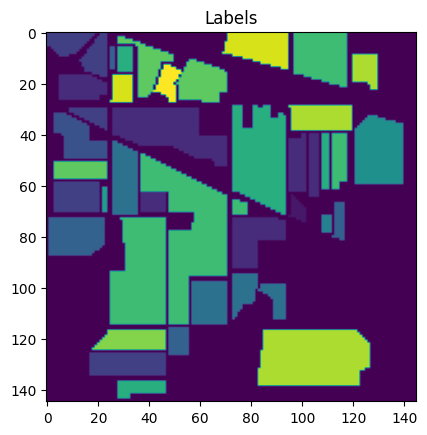

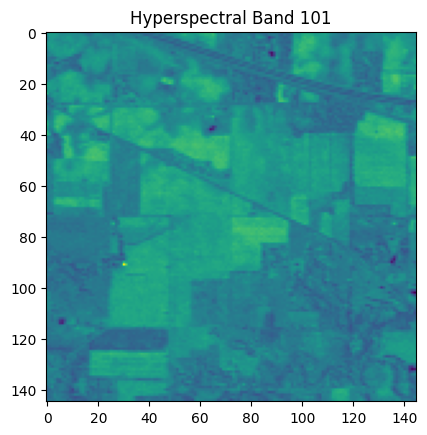

(80, 5000)
(10089, 5000)
Accuracy: 0.43
F1 Micro: 0.43
F1 Macro: 0.41
F1 Weighted: 0.44


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (350) reached and the optimization hasn't converged yet.
  warnings.warn(


Test Accuracy: 0.47
(5, 5, 200)
16
Epoch 1/1000


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.1250 - loss: 3.0983 - val_accuracy: 0.1000 - val_loss: 2.8610
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.4500 - loss: 1.8432 - val_accuracy: 0.0625 - val_loss: 2.8581
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.7250 - loss: 1.1151 - val_accuracy: 0.0625 - val_loss: 2.8577
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7375 - loss: 0.8891

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.7375 - loss: 0.8891 - val_accuracy: 0.0625 - val_loss: 2.8555
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8375 - loss: 0.6842 - val_accuracy: 0.0625 - val_loss: 2.8538
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9125 - loss: 0.5182 - val_accuracy: 0.0625 - val_loss: 2.8535
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9625 - loss: 0.4208 - val_accuracy: 0.0625 - val_loss: 2.8534
Epoch 8/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9500 - loss: 0.3177 - val_accuracy: 0.0625 - val_loss: 2.8521
Epoch 9/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9875 - loss: 0.2761 - val_accuracy: 0.0625 - val_loss: 2.8502
Epoch 10/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9875 - loss: 0.2230 - val_accuracy: 0.0625 - val_loss: 2.8481
Epoch 11/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 1.0000 - loss: 0.1798 - val_accuracy: 0.0625 - val_loss: 2.

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (350) reached and the optimization hasn't converged yet.
  warnings.warn(


Test Accuracy: 0.54
(5, 5, 200)
16
Epoch 1/1000


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.0500 - loss: 3.3029 - val_accuracy: 0.0625 - val_loss: 2.9086
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.2750 - loss: 2.0838 - val_accuracy: 0.0625 - val_loss: 2.8979
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.5250 - loss: 1.4292 - val_accuracy: 0.0625 - val_loss: 2.8975
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6562 - loss: 1.1816

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.6562 - loss: 1.1816 - val_accuracy: 0.0625 - val_loss: 2.8997
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.6875 - loss: 1.0600 - val_accuracy: 0.0625 - val_loss: 2.9014
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7750 - loss: 0.8578 - val_accuracy: 0.0625 - val_loss: 2.9021
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.7625 - loss: 0.7873 - val_accuracy: 0.0625 - val_loss: 2.9033
Epoch 8/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8438 - loss: 0.6315 - val_accuracy: 0.0625 - val_loss: 2.9058
Epoch 9/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8562 - loss: 0.6026 - val_accuracy: 0.0625 - val_loss: 2.9079
Epoch 10/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9125 - loss: 0.5009 - val_accuracy: 0.0625 - val_loss: 2.9096
Epoch 11/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8938 - loss: 0.4520 - val_accuracy: 0.0625 - val_loss: 2.

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: Undefin

Accuracy: 0.61
F1 Micro: 0.61
F1 Macro: 0.56
F1 Weighted: 0.62
Test Accuracy: 0.49
(5, 5, 200)
16
Epoch 1/1000


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 215ms/step - accuracy: 0.1191 - loss: 2.7358 - val_accuracy: 0.0411 - val_loss: 2.8648
Epoch 2/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.4913 - loss: 1.8010 - val_accuracy: 0.0411 - val_loss: 2.8643
Epoch 3/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.5859 - loss: 1.2289

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.6004 - loss: 1.1989 - val_accuracy: 0.0411 - val_loss: 2.8647
Epoch 4/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.6711 - loss: 0.9799 - val_accuracy: 0.0411 - val_loss: 2.8698
Epoch 5/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.7122 - loss: 0.8451 - val_accuracy: 0.0411 - val_loss: 2.8687
Epoch 6/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7284 - loss: 0.7543 - val_accuracy: 0.0411 - val_loss: 2.8629
Epoch 7/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8068 - loss: 0.6713 - val_accuracy: 0.0411 - val_loss: 2.8630
Epoch 8/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.8134 - loss: 0.5972 - val_accuracy: 0.0411 - val_loss: 2.8674
Epoch 9/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.8578 - loss: 0.5206 - val_accuracy: 0.0411 - val_loss: 2.8686
Epoch 10/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8621 - loss: 0.4613 - val_accuracy: 0.0411 - val_loss: 2.8

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is

Accuracy: 0.67
F1 Micro: 0.67
F1 Macro: 0.56
F1 Weighted: 0.68
Test Accuracy: 0.53
(5, 5, 200)
16
Epoch 1/1000


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 0.1858 - loss: 2.7743 - val_accuracy: 0.0769 - val_loss: 2.7521
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.4269 - loss: 1.5577 - val_accuracy: 0.0769 - val_loss: 2.7296
Epoch 3/1000


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5533 - loss: 1.1817 - val_accuracy: 0.0923 - val_loss: 2.7251
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.6746 - loss: 0.9817 - val_accuracy: 0.0769 - val_loss: 2.7293
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6931 - loss: 0.8662 - val_accuracy: 0.0769 - val_loss: 2.7241
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.6996 - loss: 0.7937 - val_accuracy: 0.0769 - val_loss: 2.7120
Epoch 7/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7758 - loss: 0.6791 - val_accuracy: 0.0769 - val_loss: 2.7029
Epoch 8/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7764 - loss: 0.6427 - val_accuracy: 0.0769 - val_loss: 2.7060
Epoch 9/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8039 - loss: 0.5569 - val_accuracy: 0.0769 - val_loss: 2.6915
Epoch 10/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8494 - loss: 0.4963 - val_accuracy: 0.0769 - val_loss: 2.6

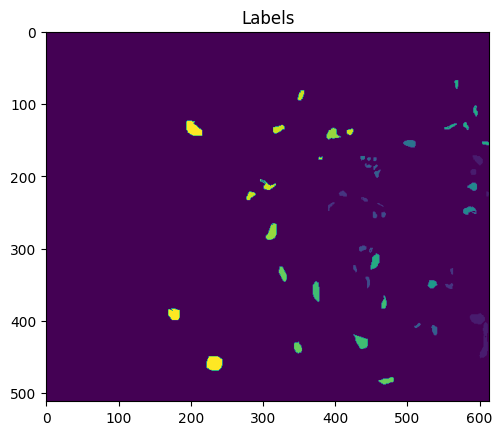

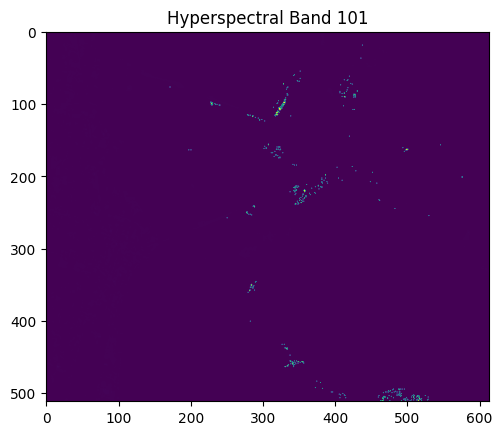

(65, 4400)
(5081, 4400)
Accuracy: 0.59
F1 Micro: 0.59
F1 Macro: 0.51
F1 Weighted: 0.58
Test Accuracy: 0.64
(5, 5, 176)
13
Epoch 1/1000


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (350) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.0769 - loss: 2.7167 - val_accuracy: 0.0769 - val_loss: 2.6537
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.2154 - loss: 2.1434 - val_accuracy: 0.0769 - val_loss: 2.6544
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.3692 - loss: 1.9945 - val_accuracy: 0.0769 - val_loss: 2.6556
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4000 - loss: 1.8448

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.4000 - loss: 1.8448 - val_accuracy: 0.0769 - val_loss: 2.6572
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.3846 - loss: 1.7003 - val_accuracy: 0.0769 - val_loss: 2.6593
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.4923 - loss: 1.5831 - val_accuracy: 0.0769 - val_loss: 2.6619
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.5231 - loss: 1.4963 - val_accuracy: 0.0769 - val_loss: 2.6648
Epoch 8/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.5231 - loss: 1.4246 - val_accuracy: 0.0769 - val_loss: 2.6673
Epoch 9/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.5846 - loss: 1.3539 - val_accuracy: 0.0769 - val_loss: 2.6698
Epoch 10/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.5692 - loss: 1.2820 - val_accuracy: 0.0769 - val_loss: 2.6724
Epoch 11/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.6308 - loss: 1.2152 - val_accuracy: 0.0769 - val_loss: 2.

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (350) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.0154 - loss: 2.7165 - val_accuracy: 0.0769 - val_loss: 2.7390
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.3692 - loss: 2.2454 - val_accuracy: 0.0769 - val_loss: 2.7389
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.3615 - loss: 2.0391 - val_accuracy: 0.0769 - val_loss: 2.7351
Epoch 4/1000


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.3846 - loss: 1.8272 - val_accuracy: 0.0769 - val_loss: 2.7284
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.3385 - loss: 1.6801 - val_accuracy: 0.0769 - val_loss: 2.7186
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.3462 - loss: 1.5714 - val_accuracy: 0.0769 - val_loss: 2.7063
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.3769 - loss: 1.4884 - val_accuracy: 0.1538 - val_loss: 2.6934
Epoch 8/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.4000 - loss: 1.4196 - val_accuracy: 0.0769 - val_loss: 2.6818
Epoch 9/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.4077 - loss: 1.3462 - val_accuracy: 0.0769 - val_loss: 2.6714
Epoch 10/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.4385 - loss: 1.2825 - val_accuracy: 0.0769 - val_loss: 2.6625
Epoch 11/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.5846 - loss: 1.2214 - val_accuracy: 0.0769 - val_loss: 2.

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.73
F1 Micro: 0.73
F1 Macro: 0.70
F1 Weighted: 0.73
Test Accuracy: 0.76
(5, 5, 176)
13
Epoch 1/1000


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (350) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 205ms/step - accuracy: 0.0679 - loss: 2.7208 - val_accuracy: 0.0769 - val_loss: 2.7247
Epoch 2/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3676 - loss: 2.0731 - val_accuracy: 0.0769 - val_loss: 2.7110
Epoch 3/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.3906 - loss: 1.7335

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.3928 - loss: 1.7362 - val_accuracy: 0.0769 - val_loss: 2.7021
Epoch 4/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.4635 - loss: 1.5146 - val_accuracy: 0.0769 - val_loss: 2.6958
Epoch 5/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5234 - loss: 1.4382 - val_accuracy: 0.0769 - val_loss: 2.6871
Epoch 6/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5400 - loss: 1.3251 - val_accuracy: 0.0769 - val_loss: 2.6784
Epoch 7/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5588 - loss: 1.2187 - val_accuracy: 0.0769 - val_loss: 2.6766
Epoch 8/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.6098 - loss: 1.1323 - val_accuracy: 0.0769 - val_loss: 2.6763
Epoch 9/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.5903 - loss: 1.0634 - val_accuracy: 0.0769 - val_loss: 2.6713
Epoch 10/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.6650 - loss: 1.0129 - val_accuracy: 0.0769 - val_loss: 2.6

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.76
F1 Micro: 0.76
F1 Macro: 0.72
F1 Weighted: 0.76
Test Accuracy: 0.77
(5, 5, 176)
13
Epoch 1/1000


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.1475 - loss: 2.5469 - val_accuracy: 0.0769 - val_loss: 2.7306
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3775 - loss: 1.9189 - val_accuracy: 0.0769 - val_loss: 2.7245
Epoch 3/1000
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.3477 - loss: 1.6316

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3714 - loss: 1.6179 - val_accuracy: 0.0769 - val_loss: 2.7212
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.4944 - loss: 1.4362 - val_accuracy: 0.0769 - val_loss: 2.7187
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4883 - loss: 1.3119 - val_accuracy: 0.0769 - val_loss: 2.7208
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6208 - loss: 1.1873 - val_accuracy: 0.0769 - val_loss: 2.7264
Epoch 7/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5224 - loss: 1.1363 - val_accuracy: 0.0769 - val_loss: 2.7284
Epoch 8/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6290 - loss: 1.0142 - val_accuracy: 0.0769 - val_loss: 2.7480
Epoch 9/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6267 - loss: 1.0403 - val_accuracy: 0.0769 - val_loss: 2.7690
Epoch 10/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6715 - loss: 0.9327 - val_accuracy: 0.0769 - val_loss: 2.7

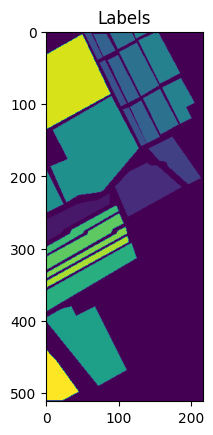

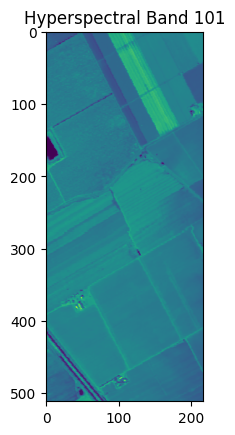

(80, 5100)
(53969, 5100)
Accuracy: 0.78
F1 Micro: 0.78
F1 Macro: 0.79
F1 Weighted: 0.78


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (350) reached and the optimization hasn't converged yet.
  warnings.warn(


Test Accuracy: 0.83
(5, 5, 204)
16
Epoch 1/1000


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.0250 - loss: 3.3641 - val_accuracy: 0.1250 - val_loss: 2.9393
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.2125 - loss: 1.9510 - val_accuracy: 0.1250 - val_loss: 2.9227
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.3000 - loss: 1.7331 - val_accuracy: 0.0875 - val_loss: 2.9050
Epoch 4/1000


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.4000 - loss: 1.5131 - val_accuracy: 0.0625 - val_loss: 2.8877
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.4500 - loss: 1.2980 - val_accuracy: 0.0625 - val_loss: 2.8703
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.6250 - loss: 1.1521 - val_accuracy: 0.0625 - val_loss: 2.8523
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.6500 - loss: 1.0410 - val_accuracy: 0.0625 - val_loss: 2.8354
Epoch 8/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.7500 - loss: 0.9265 - val_accuracy: 0.0625 - val_loss: 2.8190
Epoch 9/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8000 - loss: 0.8241 - val_accuracy: 0.0625 - val_loss: 2.8057
Epoch 10/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.8125 - loss: 0.7612 - val_accuracy: 0.0625 - val_loss: 2.7941
Epoch 11/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.8375 - loss: 0.6987 - val_accuracy: 0.0625 - val_loss: 2.

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (350) reached and the optimization hasn't converged yet.
  warnings.warn(


Test Accuracy: 0.83
(5, 5, 204)
16
Epoch 1/1000


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.0938 - loss: 3.0917 - val_accuracy: 0.0625 - val_loss: 2.8757
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.3500 - loss: 2.0260 - val_accuracy: 0.0625 - val_loss: 2.8651
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.4062 - loss: 1.7483 - val_accuracy: 0.0625 - val_loss: 2.8525
Epoch 4/1000


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.4812 - loss: 1.4273 - val_accuracy: 0.1250 - val_loss: 2.8419
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.6562 - loss: 1.1733 - val_accuracy: 0.1250 - val_loss: 2.8320
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.6313 - loss: 1.0426 - val_accuracy: 0.0625 - val_loss: 2.8227
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.6687 - loss: 0.9442 - val_accuracy: 0.0625 - val_loss: 2.8160
Epoch 8/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.7063 - loss: 0.8853 - val_accuracy: 0.0625 - val_loss: 2.8114
Epoch 9/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.7312 - loss: 0.8153 - val_accuracy: 0.0625 - val_loss: 2.8082
Epoch 10/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.7937 - loss: 0.7411 - val_accuracy: 0.0625 - val_loss: 2.8059
Epoch 11/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8313 - loss: 0.6896 - val_accuracy: 0.0625 - val_loss: 2.

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 212ms/step - accuracy: 0.0576 - loss: 3.2066 - val_accuracy: 0.0625 - val_loss: 2.9124
Epoch 2/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.4306 - loss: 1.6596 - val_accuracy: 0.0625 - val_loss: 2.8731
Epoch 3/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.5469 - loss: 1.4255

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.5273 - loss: 1.3994 - val_accuracy: 0.0625 - val_loss: 2.8403
Epoch 4/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.6039 - loss: 1.1357 - val_accuracy: 0.0625 - val_loss: 2.8251
Epoch 5/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.6675 - loss: 0.9779 - val_accuracy: 0.0625 - val_loss: 2.8076
Epoch 6/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.6938 - loss: 0.8775 - val_accuracy: 0.0625 - val_loss: 2.7912
Epoch 7/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7817 - loss: 0.7841 - val_accuracy: 0.0625 - val_loss: 2.7838
Epoch 8/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8032 - loss: 0.7020 - val_accuracy: 0.0625 - val_loss: 2.7797
Epoch 9/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.8082 - loss: 0.6186 - val_accuracy: 0.0625 - val_loss: 2.7804
Epoch 10/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8316 - loss: 0.5454 - val_accuracy: 0.1250 - val_loss: 2.7

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.1577 - loss: 2.7426 - val_accuracy: 0.0625 - val_loss: 2.8420
Epoch 2/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4876 - loss: 1.4466 - val_accuracy: 0.0625 - val_loss: 2.8310
Epoch 3/1000


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6001 - loss: 1.0982 - val_accuracy: 0.0625 - val_loss: 2.8082
Epoch 4/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6373 - loss: 0.9283 - val_accuracy: 0.0625 - val_loss: 2.7822
Epoch 5/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7035 - loss: 0.7433 - val_accuracy: 0.0750 - val_loss: 2.7709
Epoch 6/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8017 - loss: 0.6517 - val_accuracy: 0.0625 - val_loss: 2.7506
Epoch 7/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8369 - loss: 0.5269 - val_accuracy: 0.1250 - val_loss: 2.7399
Epoch 8/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8248 - loss: 0.4855 - val_accuracy: 0.1750 - val_loss: 2.7234
Epoch 9/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8028 - loss: 0.4512 - val_accuracy: 0.1875 - val_loss: 2.7161
Epoch 10/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8657 - loss: 0.3992 - val_accuracy: 0.1875 - val_loss: 2.7

In [60]:
# Generate a timestamp once
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_file = f"results/results_{timestamp}.xlsx"
time_output_file = f"results_duration/classifier_times_{timestamp}.xlsx"

with pd.ExcelWriter(output_file, engine='openpyxl') as writer, pd.ExcelWriter(time_output_file, engine='openpyxl') as time_writer:
    for run_idx in range(1):
        sample_sizes = [5, 10, 25, 50]
        results = []
        time_results = []

        for i in range(5):
            hypercube, labels = extract_Features(i)
            dataset_name = hypercube_files[i]

            X_windows, y_labels, coordinates = extract_windows(hypercube, labels, window_size)
            num_of_classes = len(np.unique(y_labels))

            for idx, samples in enumerate(sample_sizes):
                X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, samples)

                # Measure and store LR time
                LR_result, LR_time = Logistic_Regression(X_train, X_test, y_train, y_test)

                # Measure and store MLP time
                MLP_result, MLP_time = Fully_Connected_Neural_Network(X_train, X_test, y_train, y_test)

                X_train, X_test, y_train, y_test, X_val, y_val = sample_from_classes_cnn(X_train, X_test, y_train, y_test, X_val, y_val)

                # Measure CNN
                cnn_test, cnn_train, CNN_time = Convolutional_Neural_Network(X_train, X_test, y_train, y_test, X_val, y_val, 1000)

                # Measure TNN
                tnn_test, TNN_time = Tensor_Neural_Network(X_train, X_test, X_val, y_train, y_test, y_val, num_of_classes, 1500)

                # Append results
                results.append([
                    dataset_name if idx == 0 else np.nan,
                    samples,
                    LR_result,
                    MLP_result,
                    cnn_test,
                    tnn_test
                ])

                time_results.append([
                    dataset_name if idx == 0 else np.nan,
                    samples,
                    LR_time,
                    MLP_time,
                    CNN_time,
                    TNN_time
                ])

        df = pd.DataFrame(results, columns=['Dataset', 'Samples', 'LR', 'MLP', 'CNN', 'TNN'])
        time_df = pd.DataFrame(time_results, columns=['Dataset', 'Samples', 'LR_time', 'MLP_time', 'CNN_time', 'TNN_time'])

        df.to_excel(writer, sheet_name=f"Run {run_idx + 1}", index=False)
        time_df.to_excel(time_writer, sheet_name=f"Run {run_idx + 1}", index=False)

print(f"All results saved to {output_file} and {time_output_file}")

In [ ]:
import os
#os.system("rundll32.exe powrprof.dll,SetSuspendState 0,1,0")

0